## Assignment 2 - Part 2 - Finding Twitter Influencers

### Top 100 Influencers

In [47]:
import pandas as pd
import tweepy
%pylab inline
import seaborn as sns

consumer_key = 'vZyOIzO8AZBgJ6U2DfjvyN9hi'
consumer_secret = 'jy8HKcp8OkQmacmyccnhaAq06e3BDBblas0f2ub0jWrRhVqan8'
access_token_key = '829374717941448704-eFTxdEdwJG67jNr8fI4vQEaCHSn7Css'
access_token_secret = '2kXFyEbXFhhi9bJNhlDpYHwak7798PhnU52Dx2YI2cak5'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api=tweepy.API(auth)

Populating the interactive namespace from numpy and matplotlib


#### Pull 5,000 Tweets from Twitter API

In [2]:
query = 'Trump'
count = 100
max_tweets = 5000
searched_tweets = []
last_id = -1
while len(searched_tweets) < max_tweets:
    count = max_tweets - len(searched_tweets)
    try:
        new_tweets = api.search(q=query, count=count, max_id=str(last_id - 1))
        if not new_tweets:
            break
        searched_tweets.extend(new_tweets)
        last_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # depending on TweepError.code, one may want to retry or wait
        # to keep things simple, we will give up on an error
        break

#### Mine Tweets for Relevant Information

This script will parse through the Twitter JSON object and pull out the attributes deemed important in part 1 (Follower & Listed Count) as well as connections between users for both the original tweet AND where applicable the tweet and user that was Retweeted.

In [37]:
trump_tweet_data = []

for tweet in searched_tweets: #Create a list of lists of the attributes of tweets
    k = [tweet.author.screen_name,tweet.author.listed_count,tweet.author.followers_count,
           tweet.text,tweet.in_reply_to_screen_name]
    
    # If a retweet object exists, pull in user name of retweet for main tweet and create an additional entry for the referenced tweet.
    if hasattr(tweet, 'retweeted_status'):
        k.append(tweet.retweeted_status.user.screen_name) # Add User that was Retweeted to main entry
        
        # Create additional entry for information about the user that was retweeted
        rt = [tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.listed_count,
              tweet.retweeted_status.user.followers_count,tweet.retweeted_status.text,
              tweet.retweeted_status.in_reply_to_screen_name,'','']
        
        trump_tweet_data.append(rt) # Add retweet info as separate entry
    
    else: k.append('')
        
    # Pull in and convert Mentions object to a list of usernames
    mention_list = []
    for user_dict in tweet.entities['user_mentions']:
        if user_dict['screen_name'] != k[-1] and user_dict['screen_name'] != k[-2]: # Fix to exclude retweets & replies from mentions
            mention_list.append(user_dict['screen_name'])
            
    k.append(mention_list)
    
    trump_tweet_data.append(k)
print trump_tweet_data[:5] 

[[u'Breznican', 668, 25832, u'BREAKING: Trump advisor Stephen Miller confirms it rubs the lotion on its skin or else it gets the hose again. https://t.co/MJuelRyLMn', None, '', ''], [u'mmikrib', 89, 1621, u'RT @Breznican: BREAKING: Trump advisor Stephen Miller confirms it rubs the lotion on its skin or else it gets the hose again. https://t.co/\u2026', None, u'Breznican', []], [u'deIiveryboy', 179, 4602, u'Simon looks like a trump supporter', None, '', ''], [u'ccrterminus', 44, 1616, u'RT @deIiveryboy: Simon looks like a trump supporter', None, u'deIiveryboy', []], [u'funder', 904, 65550, u'US intelligence community operating under presumption Russia has "ears" on the Trump team #resist #trumpleaks #amjoy https://t.co/X3UfbvzDKV', None, '', '']]


#### Convert to Dataframe

In [52]:
trump_tweet_data_df = pd.DataFrame(trump_tweet_data) #Convert it into a dataframe and publish a csv file
trump_tweet_data_df.columns = ['User','listed_count','followers_count','text','Reply_User','Retweet_User','Mention_Users']

trump_tweet_data_df.head()

,User,listed_count,followers_count,text,Reply_User,Retweet_User,Mention_Users
0,Breznican,668,25832,BREAKING: Trump advisor Stephen Miller confirm...,None,,
1,mmikrib,89,1621,RT @Breznican: BREAKING: Trump advisor Stephen...,None,Breznican,[]
2,deIiveryboy,179,4602,Simon looks like a trump supporter,None,,
3,ccrterminus,44,1616,RT @deIiveryboy: Simon looks like a trump supp...,None,deIiveryboy,[]
4,funder,904,65550,US intelligence community operating under pres...,None,,


#### Define Attribute Weights

Weights based on the two most critical attributes identified in Part 1 of the Analysis.

In [53]:
listed_count_weight = 0.44/(0.44+0.40)
follower_count_weight = 0.40/(0.44+0.40)

#### Pre-processing

Remove unnecessary columns, keep only unique users, and normalize listed & follower counts.

NOTE: The list count & follower counts must be averaged to account for the fact these numbers constantly change for top influencers.

In [54]:
from sklearn import preprocessing #Scale the data and score it

# Average counts to account for changes in top influencer's listed & followers within dataset
top_influencers_df = trump_tweet_data_df.groupby('User')[['listed_count','followers_count']].mean()

# Normalize scores so that their importance is driven by the weights.
top_influencers_df['listed_norm'] = preprocessing.scale(top_influencers_df['listed_count'])
top_influencers_df['followers_norm'] = preprocessing.scale(top_influencers_df['followers_count'])

#### Calculated Weighted User Influence Score

In [58]:
top_influencers_df['Influence Score'] = top_influencers_df['listed_norm']*listed_count_weight\
+top_influencers_df['followers_norm']*follower_count_weight

top100influencers_trump = top_influencers_df.sort('Influence Score',ascending=False)[:100]

top100influencers_trump[:20]

C:\Users\Dallas\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,listed_count,followers_count,listed_norm,followers_norm,Influence Score
User,,,,,
nytimes,186149.833333,3.368306e+07,35.681240,34.888268,35.303634
CNN,123767.666667,3.179554e+07,23.680655,32.927876,28.084093
BBCWorld,102074.000000,1.787891e+07,19.507399,18.474018,19.015313
Reuters,108322.800000,1.644380e+07,20.709494,16.983504,18.935213
realDonaldTrump,63731.000000,2.471798e+07,12.131277,25.577097,18.534049
WSJ,104179.125000,1.297827e+07,19.912366,13.384190,16.803711
HuffingtonPost,84112.500000,9.075558e+06,16.052109,9.330819,12.851495
FoxNews,57151.968750,1.325145e+07,10.865656,13.667918,12.200066
CNNEE,48651.000000,1.478568e+07,9.230307,15.261373,12.102243


#### Visualize Top 10 Influencers on Topic of Donald Trump

C:\Users\Dallas\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


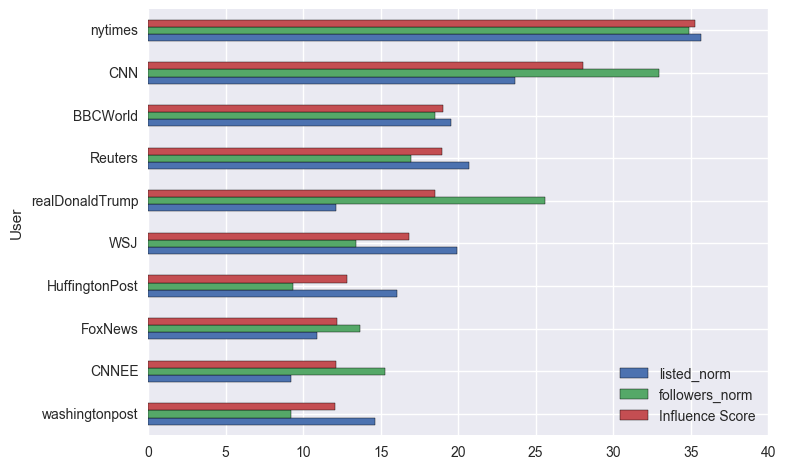

In [56]:
top100influencers_trump[['listed_norm','followers_norm','Influence Score']][:10].sort('Influence Score',ascending=True).plot(kind = 'barh')

## Influence Matrix

#### Create new DF with only relevant columns

##### Key Assumptions:
1. Their should be a reference line EACH TIME a user retweets another user (i.e. if a user retweets another user twice, their will be two entries)
2. Retweets and replies should not also count as mentions (i.e. if a user retweets a user, there will be an entry for just the retweet rathen then 1 for the retweet AND 1 for the mention).

In [61]:
influence_matrix_df = trump_tweet_data_df[['User','Reply_User','Retweet_User','Mention_Users']]
influence_matrix_df[:10]

,User,Reply_User,Retweet_User,Mention_Users
0,Breznican,None,,
1,mmikrib,None,Breznican,[]
2,deIiveryboy,None,,
3,ccrterminus,None,deIiveryboy,[]
4,funder,None,,
5,AngryLogician,None,funder,[]
6,1913Facts,EBONYMag,,[]
7,scambyarussian,None,,
8,Heleneafernande,None,scambyarussian,[]
9,lorengrush,None,,


In [62]:
influence_matrix = []

# Iterate over each of the rows creating a record (in the form of a list) for each connection
for index, row in influence_matrix_df.iterrows():
    influence_matrix.append([row['User'],row['User'],'Tweet']) # First row for the Tweet itself per instructions
    if row['Reply_User'] != None:
        influence_matrix.append([row['User'],row['Reply_User'],'Reply']) # Add Replies
    if len(row['Retweet_User']) > 0:
        influence_matrix.append([row['User'],row['Retweet_User'],'Retweet']) # Add Retweets
    for user in row['Mention_Users']:
        influence_matrix.append([row['User'],user,'Mention']) # Add Mentions

In [63]:
influence_matrix_final = pd.DataFrame(influence_matrix) #Convert it into a dataframe and publish a csv file
influence_matrix_final.columns = ['User1', 'User2', 'Action']

influence_matrix_final.head()

,User1,User2,Action
0,Breznican,Breznican,Tweet
1,mmikrib,mmikrib,Tweet
2,mmikrib,Breznican,Retweet
3,deIiveryboy,deIiveryboy,Tweet
4,ccrterminus,ccrterminus,Tweet


In [64]:
influence_matrix_final.to_csv('influence_matrix.csv',index=False)